## ProjF2 - Data Exploration

Use this document as a template to provide some exploratory analysis of your data similar to the one in ProjC1. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [49]:
# uncomment the packages you want to install
!pip install nltk
!pip install pandas
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install wordcloud
!pip install scikit-learn
!pip install spacy

In [19]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import nltk
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. Load and Visualize Data

Let's start by loading your entire dataset or a sample if it is a larger dataset.

In [42]:
### YOUR CODE HERE
train_data = pd.read_csv("../Data/train.csv")

Provide some visualization of the data. For example,
- If your data is time series, you can plot a sequence and the response or label.
- If tabular data, you can plot histograms of the data.
- If working with image recognition or segmentation, you can show an image and the corresponding output.
- If it is a video that you are processing, just show screenshots.
- If doing something with reinforcement learning, you can provide samples of the simulation environment used.

### 0. Preprocessing

#### 1 Drop Unnecessary Column (URI)

In [43]:
train_data = train_data[['article', 'highlights']]

In [44]:
train_data.head(5)

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


#### 2 Removal of Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords data
# nltk.download('stopwords')
# import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

#### 3 Removal of Punctuation 

In [46]:
# Function to preprocess text
def preprocess_text(text):
    # Get the set of English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Combine regex patterns and compile them
    pattern = re.compile(r'[^\w\s]|(\d+)')
    
    # Apply regex substitution
    text = pattern.sub('', text)
    
    # Standardize capitalization
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(filtered_words)

# Preprocess the 'article' column in train_data
train_data['processed_article'] = train_data['article'].apply(preprocess_text)

In [47]:
train_data['processed_article'].head(5)

0    associated press published est october updated...
1    cnn ralph mata internal affairs lieutenant mia...
2    drunk driver killed young woman headon crash c...
3    cnn breezy sweep pen president vladimir putin ...
4    fleetwood team still record sky bet league one...
Name: processed_article, dtype: object

### 1.1 Word Cloud

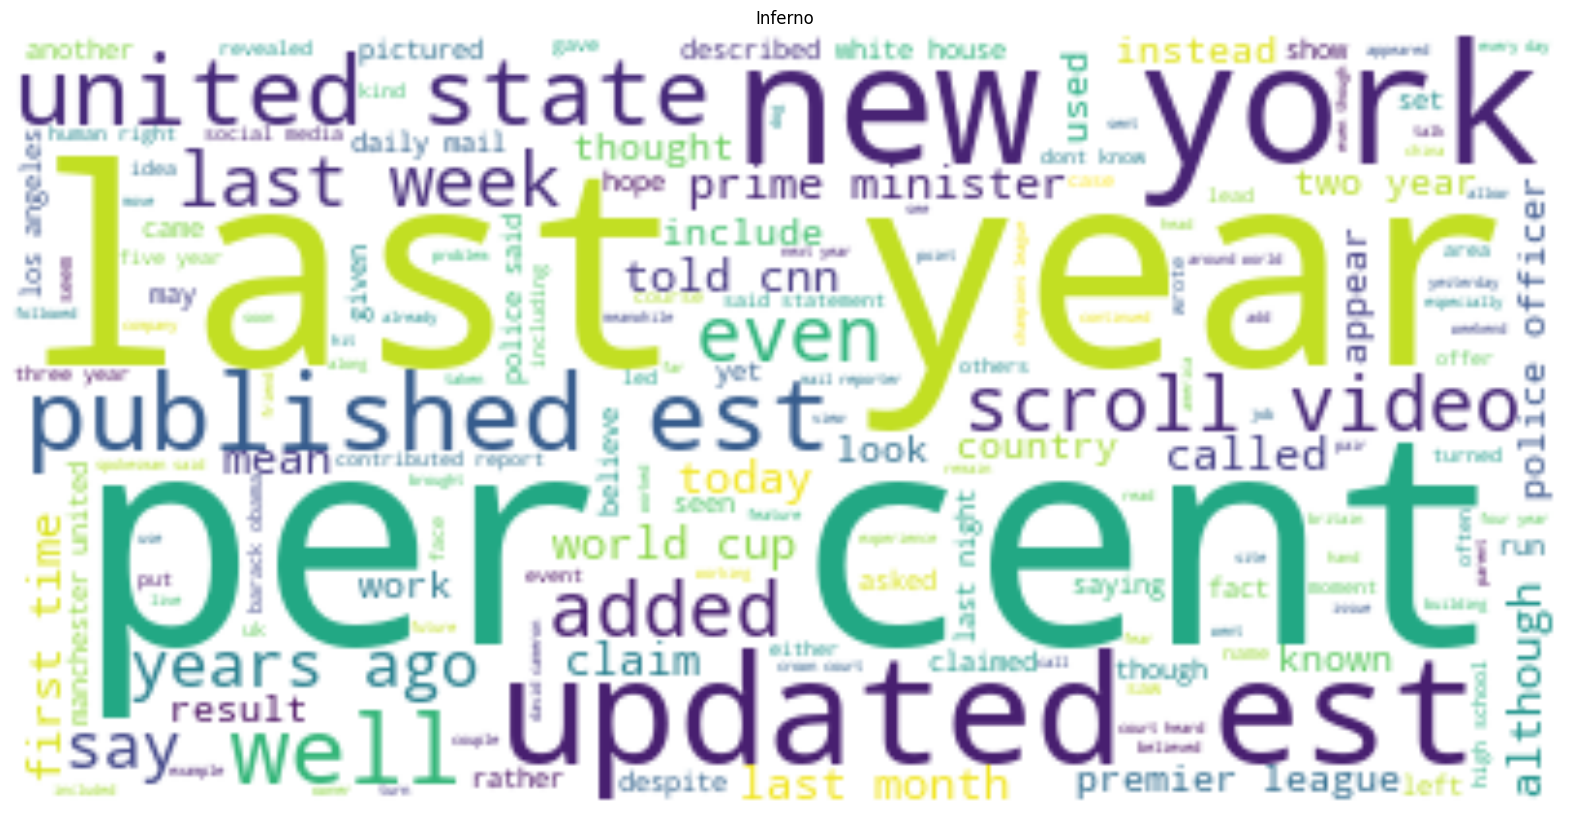

In [48]:
wordcloud_spam = WordCloud(background_color="white").generate(' '.join(train_data['processed_article']))


plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Inferno")
plt.axis("off")
plt.show()

## 1.2 Explore Ngrams

In [50]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

#### Bi-grams

<Axes: >

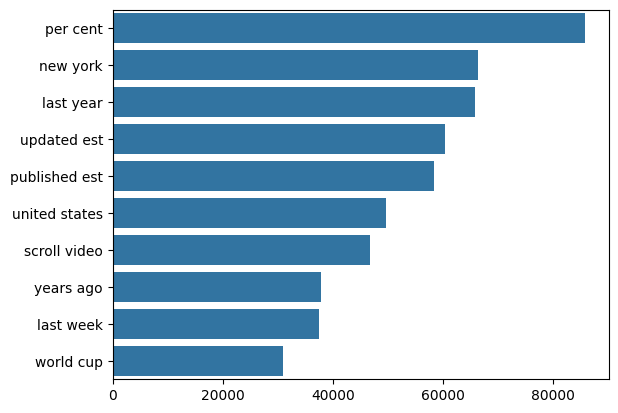

In [52]:
top_n_bigrams=get_top_ngram(train_data['processed_article'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

### 2. Compute Some Statistics from your Data

First, extract some characterisitics about the input (e.g., image size, means and standard deviation of values, sample frequency).

### 2.1 Lemma Count

In [53]:
sent_token = train_data['processed_article']

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize a dictionary to store unique lemmas and their counts
unique_lemma = {}

# Iterate through each sentence in the dataset
for sentence in sent_token:
    # Tokenize the sentence
    words = word_tokenize(sentence)
    # Lemmatize each word and count unique lemmas
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        if lemma not in unique_lemma:
            unique_lemma[lemma] = 1
        else:
            unique_lemma[lemma] += 1

# Print the number of unique lemmas
print(len(unique_lemma))

641913


### 2.2 POS Tagging Statistics

{'VBN': 3930, 'NN': 131082, 'JJS': 715, 'NNP': 520, 'RB': 6612, 'JJ': 49867, 'NNS': 37512, 'VBP': 23196, 'VBD': 16116, 'VB': 1446, 'VBZ': 5226, 'VBG': 6969, 'IN': 2034, 'RBR': 310, 'JJR': 655, 'WRB': 40, 'RP': 93, 'FW': 365, 'WP': 46, 'RBS': 45, 'MD': 47, 'DT': 53, 'WDT': 20, 'CD': 82, 'CC': 58, 'PRP$': 31, 'PRP': 30, 'EX': 10, 'POS': 2, 'NNPS': 1}


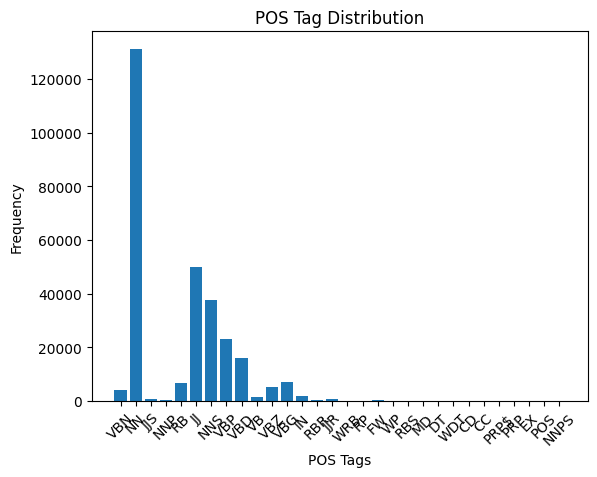

In [54]:
pos_tagged = nltk.pos_tag(train_data['processed_article'])

# Initialize a dictionary to store POS tags and their counts
pos_dict = {}

# Count the occurrences of each POS tag
for word in pos_tagged:
    if word[-1] not in pos_dict:
        pos_dict[word[-1]] = 1
    else:
        num = pos_dict.get(word[-1])
        pos_dict[word[-1]] = num + 1

# Print the dictionary containing POS tags and their counts
print(pos_dict)

# Plotting barplot for POS tags
names = list(pos_dict.keys())
values = list(pos_dict.values())
plt.bar(range(len(pos_dict)), values, tick_label=names)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution')
plt.xticks(rotation=45)
plt.show()

## 2.5 TTR Ratio
Type Token Ratio

In [55]:
types=nltk.Counter(train_data['processed_article'])
ttr=(len(types)/len(train_data['processed_article']))*100
print(ttr)

98.90321928996597


## 2.6 TF/IDF

In [62]:
corpus = train_data['processed_article']

# Create a TfidfVectorizer object and fit it to the preprocessed corpus
vectorizer = TfidfVectorizer()  
vectorizer.fit(corpus)

# Transform the preprocessed corpus into a TF-IDF matrix
tf_idf_matrix = vectorizer.transform(corpus)

# Get list of feature names that correspond to the columns in the TF-IDF matrix
words_set = vectorizer.get_feature_names_out()

# Finally, we'll create a dataframe to better show the TF-IDF scores of each document:
df_tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf_matrix, columns=words_set)
print(df_tf_idf)

        __  ___  ____  _____  ______  _______  ________  __________  \
0        0    0     0      0       0        0         0           0   
1        0    0     0      0       0        0         0           0   
2        0    0     0      0       0        0         0           0   
3        0    0     0      0       0        0         0           0   
4        0    0     0      0       0        0         0           0   
...     ..  ...   ...    ...     ...      ...       ...         ...   
287108   0    0     0      0       0        0         0           0   
287109   0    0     0      0       0        0         0           0   
287110   0    0     0      0       0        0         0           0   
287111   0    0     0      0       0        0         0           0   
287112   0    0     0      0       0        0         0           0   

        ___________  ____________  ...  ﬂeeing  ﬂeet  ﬂexible  ﬂight  ﬂights  \
0                 0             0  ...       0     0        0      

### 3. Inference and Comment on Your Data
Next, provide some characteristics about your output (e.g., histograms, spatial distribution of bounding boxes in the case of object detection, etc.). In the case of cases such as tasks such as reinforcement learning, you can provide details about the desired output and rewards used. You can show some correlations between inputs and outputs if possible.

Answer these questions as appropriate?

- Is your data balanced?
    
    Not exactly. From our POS tagging statistics, we see that the adjectives 'JJ' are the most frequent part-of-speech used in news articles.


- Are there disparities in your input data? Does it show some specific patterns?
    1) Stopwords - The presence of stopwords can introduce noise in the data. After we implement stop words removal, we see significant differences in the frequency distribution of words indicating their presence.
    2) Part-of-Speech (POS) tagging - According to POS, adjectives and nouns have a very high frequency as compared to other POS tags such as verbs, conjunctions, modals. This indicates that certain linguistic or grammatical features are less common in the input text.
    3) Writing style - POS tagging suggest variations in laguage styles and contents. This may impact summarization model.
    4) Language and Vocabulary - The input data consists of news articles only in English language. Thus based on different publications, use of language and vocabulary changes. 

Here, we have two columns / attributes in our data. The "Article" attribute is the entire article in its original format and level of detail as published. The "Highlights" format has the highlights or the main summary of the corresponding article.
In our exploration, we are mainly exploring the article attribute.
First we have processed it by removing stopwords, tokenizing it, removing numbers and normalizing capitalization.

Then, we have visualized our article input data from a variety of angles, which we will talk about below.

Wordcloud:
- Why we picked that graph/viz and what did we want to explore?<br>
A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance. It's often used to explore the most common words in a corpus and to identify prominent themes or topics.
- What does the result tell us?<br>
The result of a word cloud provides a quick overview of the most frequently occurring words in the text data. It helps in identifying dominant themes, keywords, or topics within the corpus. The larger the word appears in the word cloud, the more frequently it occurs in the text data.<br>
In our dataset, after filtering out generic words typically associated with newspaper content (e.g., "year," "published," etc.), we can derive meaningful insights regarding the newspaper's prevalent topics of coverage. Notably, recurring terms such as "police officers," "New York," "The White House," "Premier League," and "Prime Minister" emerge as prominent subjects within the publication's reporting focus.
This observation suggests that the newspaper frequently covers news related to law enforcement activities involving police officers, developments and events in New York, political affairs concerning The White House and the Prime Minister, as well as sports updates, particularly pertaining to the Premier League. By identifying these recurring themes, we gain valuable understanding into the newspaper's editorial priorities and areas of emphasis, aiding in further analysis and interpretation of its content.

Bi-grams:
- Why we picked that graph/viz and what did we want to explore?<br>
Bi-grams are pairs of adjacent words in a sequence of text. Analyzing bi-grams can provide insights into the relationship between words and help in understanding common phrases or expressions within the text data.
- What does the result tell us?<br>
By examining bi-grams, we can identify commonly co-occurring pairs of words, which can offer insights into specific language patterns or structures present in the text. For example, identifying frequent bi-grams might reveal common phrases or expressions used in the text.<br>
In our dataset, we discern a prevalent usage of comparisons within the newspaper's reporting style, evident from the frequent occurrence of specific bi-grams such as "year old," "percent," "last year," "last week," and "years ago." These bi-grams distinctly indicate a tendency to juxtapose current information with past data, thereby emphasizing comparisons and temporal relationships. This observation underscores the newspaper's analytical approach, employing historical context and comparative frameworks to elucidate trends, developments, and changes over time within the reported subjects.

POS Tag distribution:
- Why we picked that graph/viz and what did we want to explore?<br>
POS (Part-of-Speech) tagging involves labeling words in a text corpus with their corresponding part of speech, such as noun, verb, adjective, etc. Analyzing the distribution of POS tags can provide insights into the grammatical structure and linguistic characteristics of the text.
- What does the result tell us?<br>
The result of POS tag distribution analysis helps in understanding the composition of the text in terms of different parts of speech. It can reveal patterns of language usage, syntactic structures, and even stylistic features. For example, a higher frequency of verbs might indicate a more action-oriented or dynamic text, while a prevalence of adjectives could suggest descriptive or qualitative content.<br>
For our dataset, we observe a preponderance of nouns (NN), adjectives (JJ) and proper nouns singular (NNP), indicating a text abundant in descriptive details and exhibiting a high level of articulation (as suggested by the high frequency of adjectives). The prevalence of proper nouns suggests that prominent entities are frequently referenced, while the inclusion of common nouns implies a discussion of general interests or topics. This distribution reflects a well-crafted text that not only describes with precision but also introduces named entities and discusses broader concepts, enriching the overall content.

TF/IDF (Term Frequency-Inverse Document Frequency):
- Why we picked that graph/viz and what did we want to explore?<br>
TF/IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. It helps in identifying key terms that are distinct or unique to a particular document compared to others in the corpus.
- What does the result tell us?<br>
By calculating TF/IDF scores for each term in the corpus, we can identify terms that are highly relevant or characteristic of specific documents. This analysis helps in extracting meaningful insights and understanding the distinctiveness of documents within the corpus. Terms with higher TF/IDF scores are considered more important or representative of the content of a particular document.